# Snuffelfiets kwartaalrapportages

## Settings.

In [1]:
# Generieke imports, variabelen en functies.

from pathlib import Path

import numpy as np
import pandas as pd

from snuffelfiets import inlezen, opschonen, analyse, plotting

api_key = '3285a69e-3e54-42b2-a6e0-a552d9c42b11'  # voeg hier de API key toe

data_directory = Path('~','kwartaalrapportage').expanduser()
prefix = 'api_gegevens'

# date range selection settings
quarter = 'Q2'
year = 2023
quarters = {
    'Q1': [1, 2, 3], 
    'Q2': [4, 5, 6], 
    'Q3': [7, 8, 9], 
    'Q4': [10, 11, 12], 
}
yq = f'{year}_{quarter}'

# data processing settings
error_code_selection = []
rit_splitter_interval = 1800  # s
ritfilters = dict(
    min_measurements=2,     # #
    max_duration=360,       # minutes
    max_distance=200,       # kilometers
    min_average_speed=1,    # km/h
    max_average_speed=35,   # km/h
    )
threshold_pm2_5 = 100

# mapbox settings (in degrees latlon)
b = {
    'N': [52.303634, 5.013507],
    'Z':  [51.858631, 5.040462],
    'O':  [51.954780, 5.627990],
    'W':  [52.226808, 4.794457],
}
mapbox_center = {
    'lat': b['Z'][0] + 0.5 * (b['N'][0] - b['Z'][0]),
    'lon': b['W'][1] + 0.5 * (b['O'][1] - b['W'][1]),
}
mapbox_extent = 1
hexagon_size = 0.010
hexbin_args = {
    'agg_func': np.nanmean,
    'color_continuous_scale': plotting.discrete_colorscale(),
    'range_color': [0, threshold_pm2_5],
    'min_count': 2,
    'animation_frame': None,
    'width': 1920,
    'height': 1080,
    'opacity': 1.0,
    'zoom': 10,
    'center': mapbox_center,
    }
# add Utrecht polygons
# Import Utrecht province and township polygons
filepaths = plotting.download_borders_utrecht(data_directory)
provincies, gemeenten = plotting.get_borders_utrecht(data_directory, *filepaths)
mapbox_layers = [{
    "name": "Gemeenten",
    "below": 'traces',
    "sourcetype": "geojson",
    "type": "line",
    "color": "gray",
    "source": gemeenten,
    }, 
    {
    "name": "Provincies",
    "below": 'traces',
    "sourcetype": "geojson",
    "type": "line",
    "color": "red",
    "source": provincies,
    }]
layout_args = {
    'mapbox_style': 'open-street-map',
    'coloraxis_showscale': False,
    'mapbox_layers': mapbox_layers,
    }

# Directories
output_directory = Path(data_directory, yq)
output_directory.mkdir(parents=True, exist_ok=True)

print(f'Analysing quarter {yq}; writing output to {output_directory}.')


Analysing quarter 2023_Q2; writing output to C:\Users\milos\kwartaalrapportage\2023_Q2.


## Read data from monthly CSV's.


In [2]:
# Read data from saved csvs.
dfs = []
for m in quarters[quarter]:
    filename = f'{prefix}_{year}-{m:02d}.csv'
    p = Path(data_directory, filename)
    df = pd.read_csv(p)
    dfs.append(df)
df = pd.concat(dfs)

print(f'Read {df.shape[0]} measurements.')


Read 970166 measurements.


## Data preparation

In [3]:
# Get some insight in the error modes present in the dataset.
opschonen.analyse_errors(df)


code          0: count          909140
code         32: count           39877
             32:                        type       : Allowed Error, device maybe indoors
             32:                        description: GPS ERROR 2: No GPS Fix
code        512: count            3278
            512:                        type       : Critical Error
            512:                        description: PM ERROR 1: Sensor Not Found
code        533: count            6496
              1:                        type       : Critical Error
              1:                        description: ACCELEROMETER ERROR 1: Sensor Not Found
              4:                        type       : Critical Error
              4:                        description: BME ERROR 1: Sensor Not Found
             16:                        type       : Critical Error
             16:                        description: GPS ERROR 1: Sensor Not Found
            512:                        type       : Critical Err

In [4]:
# Drop the errors.
df = opschonen.verwijder_errors(df, error_codes=error_code_selection)


Removing            3278 measurements with error_code             512
Removing           39877 measurements with error_code              32
Removing              99 measurements with error_code             544
Removing           10495 measurements with error_code            2048
Removing             616 measurements with error_code            2080
Removing             110 measurements with error_code            2560
Removing              55 measurements with error_code            2592
Removing            6496 measurements with error_code             533

Error codes remaining: [0]
Measurements remaining: 909140.


In [5]:
# Convert timestamps to datetime objects and add dt columns.
df = analyse.bewerk_timestamp(df, split=True)


Added ['date_time', 'day', 'week', 'month', 'quarter', 'year'] columns to dataframe.


In [6]:
# Split measurements into rides and add cycle stat columns.
df = analyse.split_in_ritten(df, t_seconden=rit_splitter_interval)


Added ['duur', 'afstand', 'snelheid', 'rit_id'] columns to dataframe.
Identified 6833 rides in the dataset.


In [7]:
# Filter the rides.
df = analyse.filter_ritten(df, **ritfilters)


        41 rides were removed because number of measurements was < 2
        82 rides were removed because duration was >= 360 minutes
         0 rides were removed because distance was >= 200 kilometers
        15 rides were removed because average speed was >= 35 km/h
      1073 rides were removed because average speed was < 1 km/h


## Summary Snuffelfiets statistics.

In [8]:
def printfun(period, sumstats):

    print(f'\n==== {period} ====\n')

    print(f"Aantal fietsers: {sumstats['fietsers']['N']}\n")

    print(f"{' ':20} {'totaal':12} {'gemiddeld':12} {'topper':12}")
    print(f'-' * 56)
    stat = 'uren'
    print(f"FIETSTIJD [uur]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'afstand'
    print(f"AFSTAND    [km]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'ritten'
    print(f"RITTEN      [#]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")


In [9]:
# Print the summary statistics for the quarter.
sumstats = analyse.summary_stats(df)
printfun(quarter, sumstats)



==== Q2 ====

Aantal fietsers: 76

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:   3220.392222    42.373582   152.000000
AFSTAND    [km]:  37727.389295   496.413017  2478.985541
RITTEN      [#]:   5622.000000    73.973684   284.000000


In [10]:
# Print the summary statistics for the months in the quarter.
for m, dfm in df.groupby('month'):
    sumstats = analyse.summary_stats(dfm)
    printfun(f'{year}{m:02d}', sumstats)



==== 202304 ====

Aantal fietsers: 69

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    993.335000    14.396159    55.000000
AFSTAND    [km]:  11484.542512   166.442645   757.489613
RITTEN      [#]:   1699.000000    24.623188    77.000000

==== 202305 ====

Aantal fietsers: 69

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:   1112.581944    16.124376    52.000000
AFSTAND    [km]:  13009.162621   188.538589   891.509493
RITTEN      [#]:   1907.000000    27.637681   108.000000

==== 202306 ====

Aantal fietsers: 62

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:   1114.475278    17.975408    52.000000
AFSTAND    [km]:  13233.684162   213.446519   968.323732
RITTEN      [#]:   2016.000000    32.516129    99.000000


## Air quality evaluation

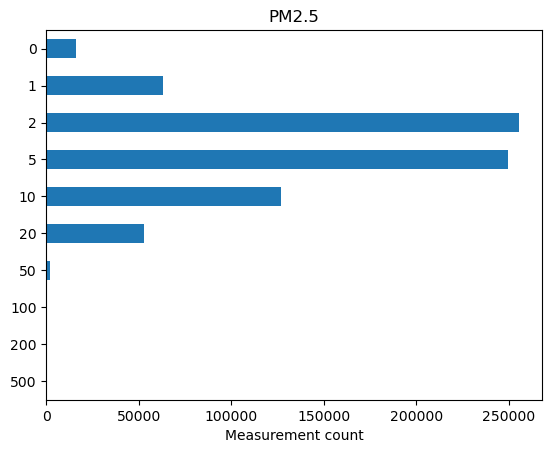

In [11]:
# Plot categorical hist of PM2.5 values.
def plot_hbar_cat(df, bins, labels, title=''):
    df[f'{var}_cat'] = pd.cut(df[var], bins=bins, labels=labels)
    ax = df[['entity_id', f'{var}_cat']].groupby(f'{var}_cat', observed=False).count().plot.barh(stacked=True, legend=False)
    ax.invert_yaxis()
    ax.axes.get_yaxis().get_label().set_visible(False)
    ax.axes.get_xaxis().set_label_text("Measurement count")
    ax.set_title(title)

var = 'pm2_5'
bins = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
labels = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]
plot_hbar_cat(df, bins, labels, title='PM2.5')


<Axes: >

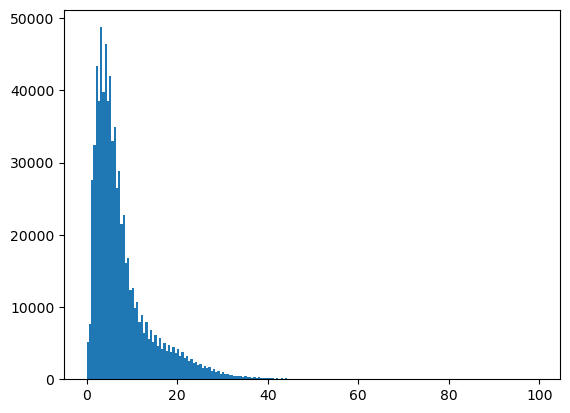

In [12]:
# Limit the PM2.5 values. FIXME: we need a better and validated method
df['pm2_5'][df['pm2_5'] >= threshold_pm2_5] = np.nan

# Plot the histogram.
df['pm2_5'].hist(bins=200, grid=False)


In [13]:
## Hexbin plots of PM2.5

# Remove datapoints outside of the map area 
#   because it would take a very long time to process large areas.
#   TODO: doe dit op ritniveau (verwijderen ritten deels of geheel buiten de target area)
latlon = {
    'latitude': {'center': mapbox_center['lat'], 'extent': mapbox_extent},
    'longitude': {'center': mapbox_center['lon'], 'extent': mapbox_extent},
}
df = opschonen.filter_lat_lon(df, latlon)

# Plot the data for each month.
for m, dfm in df.groupby('month'):

    yyyymm = f'{year}{m:02d}'
    hexbin_args['title'] = yyyymm
    fig = plotting.hexbin_mapbox(dfm, hexagon_size, hexbin_args, layout_args)

    # Save image
    filestem = f'{yyyymm}_hexbin'
    output_stem = Path(output_directory, filestem)
    fig.write_html(f"{output_stem}.html")
    fig.write_image(f"{output_stem}.png")
    fig.write_image(f"{output_stem}.pdf")


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:175: RuntimeWarning: Mean of empty slice
  lattice1[i, j] = agg_func(vals)
c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:182: RuntimeWarning: Mean of empty slice
  lattice2[i, j] = agg_func(vals)
c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:182: RuntimeWarning:

Mean of empty slice



## Uitgelicht 2023-Q1: Fijnstof en regen.

In [14]:
# Specify the date range.
import calendar
months = quarters[quarter]
lastday = calendar.monthrange(year, quarters[quarter][2])[1]
dt_min = f'{year}-{months[0]}-1 00:00:00'
dt_max = f'{year}-{months[2]}-{lastday} 23:59:59'

# Import the weather data.
dfr = analyse.import_knmi_data(dt_min, dt_max, interval='dag', stations=[260], variables=['RH'])
dfr.RH = dfr.RH.values / 10  # RH: Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)


In [15]:
# Print the monthly pm2.5 average.
df.loc[: , ['month', 'pm2_5']].groupby('month').mean()


,pm2_5
month,
4,8.836039
5,8.219602
6,6.814119


In [16]:
# Print the monthly rainfall sum.
dfr['month'] = dfr.index.month
dfr.loc[: , ['month', 'RH']].groupby('month').sum()


,RH
month,
4,66.8
5,55.3
6,14.2


In [17]:
# Calculate the mean daily PM2.5 value.
sfday = df.loc[:, ['pm2_5', 'day', 'month', 'year']].groupby(['day', 'month', 'year']).mean()
# Add to the weather data frame.
dfr['pm2_5'] = np.array(sfday['pm2_5'])


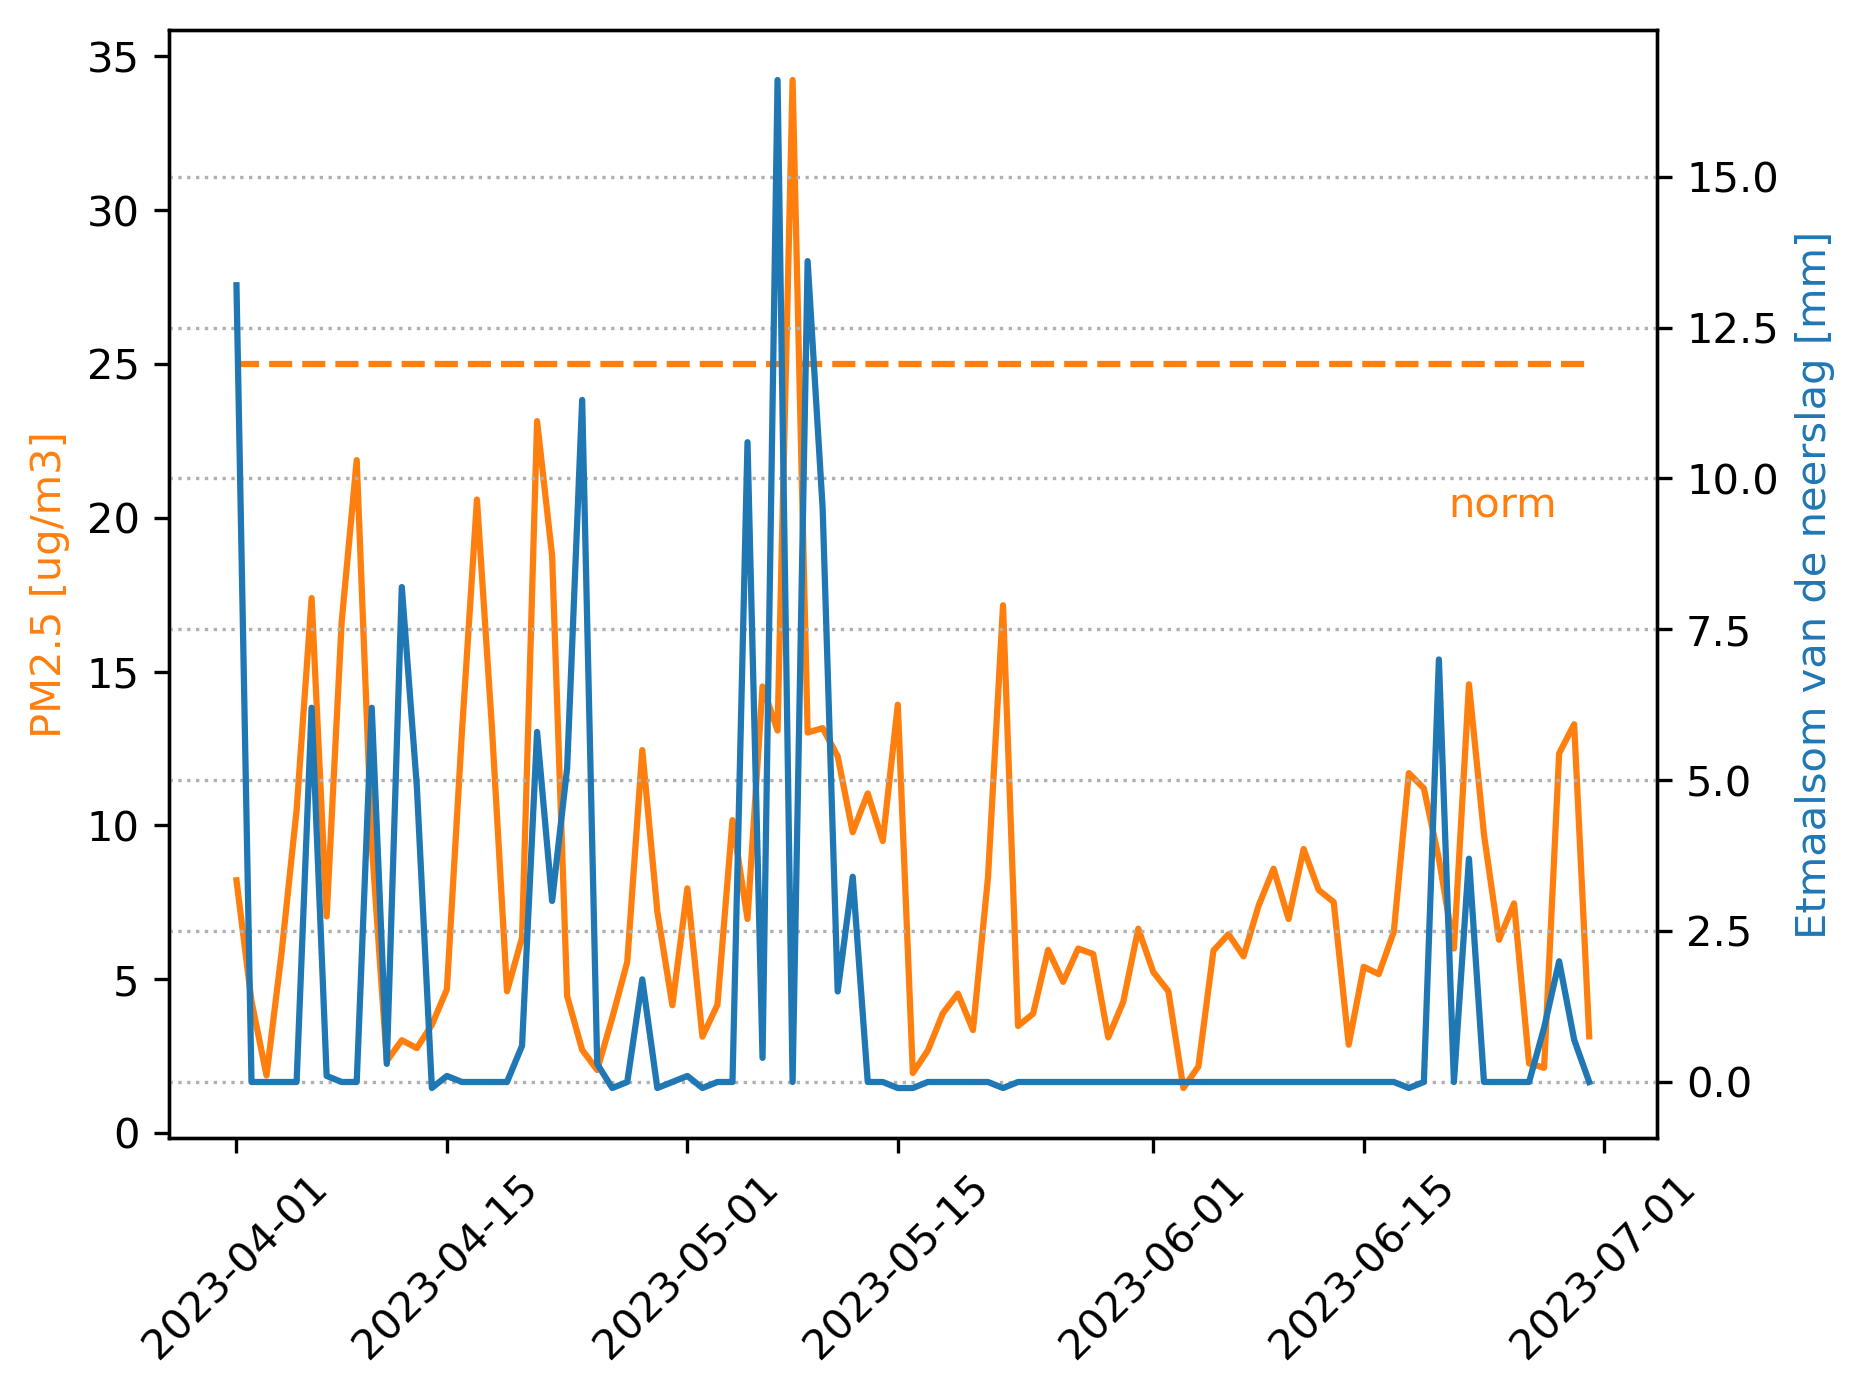

In [18]:
# Plot the data.
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(dpi=300)
ax2 = ax1.twinx()

ax1.plot(dfr.index, dfr.pm2_5, c='C1')
ax2.plot(dfr.index, dfr.RH, c='C0')

ax1.set_ylabel('PM2.5 [ug/m3]', color='C1')
ax2.set_ylabel('Etmaalsom van de neerslag [mm]', color='C0')

ax1.plot([dfr.index[0], dfr.index[-1]], [25, 25], c='C1',linestyle='--')
plt.text(0.86, 0.56, 'norm', c='C1', transform=ax1.transAxes)
ax1.xaxis.set_tick_params(rotation=45)
plt.grid(linestyle=':')


## Uitgelicht 2023-Q2: Fietsgedrag.


In [19]:
# Total number of rides.
Nritten = len(np.unique(df.loc[:,['rit_id']]))


In [20]:
print("We geven jullie elk kwartaal hiernaast de Toppers, maar niet elk ritje kan uitzonderlijk zijn.")
print(f"We zoomen dit keer in op de {Nritten} ritten die er gemaakt zijn dit kwartaal.")
print("Hoe ziet zo’n ritje er over het algemeen uit en waar fietsen jullie het meest?")


We geven jullie elk kwartaal hiernaast de Toppers, maar niet elk ritje kan uitzonderlijk zijn.
We zoomen dit keer in op de 5577 ritten die er gemaakt zijn dit kwartaal.
Hoe ziet zo’n ritje er over het algemeen uit en waar fietsen jullie het meest?


In [21]:
# Get aggregated rides dataframe.
options = {
    'rit_id': ['count'],
    'duur':['sum'],
    'afstand': ['sum'],
    'snelheid': ['mean'],
    }
df_ritten = df.groupby(['entity_id', 'rit_id']).agg(options)
df_ritten = df_ritten.reset_index(level=['entity_id', 'rit_id'])
cols = ['entity_id', 'rit_id', 'aantal_waarn', 'duur', 'afstand', 'snelheid_mean']
df_ritten = df_ritten.set_axis(cols, axis=1)
df_ritten


,entity_id,rit_id,aantal_waarn,duur,afstand,snelheid_mean
0,352753092446002,146,22,0 days 00:06:22,151.707551,0.577958
1,352753092446002,147,33,0 days 00:14:29,726.815740,1.396375
2,352753092446002,148,121,0 days 00:24:00,6192.509355,4.300354
3,352753092446002,149,36,0 days 00:06:32,904.070214,2.307317
4,352753092446002,150,13,0 days 00:02:42,66.221604,0.407757
...,...,...,...,...,...,...
5572,359215101866052,6829,88,0 days 00:22:00,3998.382087,3.594241
5573,359215101866052,6830,126,0 days 00:25:11,6868.678441,4.548468
5574,359215101866052,6831,64,0 days 00:12:54,2480.052076,3.352162
5575,359215101866052,6832,81,0 days 00:14:50,3200.448415,3.604039


In [22]:
# Perform unit conversions.
df_ritten['duur_h'] = df_ritten['duur'].dt.total_seconds() / 3600  # h
df_ritten['afstand_km'] = df_ritten['afstand'] / 1000  # km
df_ritten['snelheid_mean_kph'] = df_ritten['snelheid_mean'] / 1000 * 3600 # kph


array([[<Axes: title={'center': 'duur_h'}>,
        <Axes: title={'center': 'afstand_km'}>,
        <Axes: title={'center': 'snelheid_mean_kph'}>]], dtype=object)

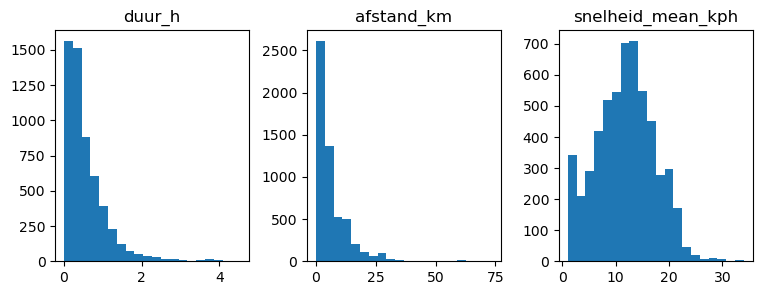

In [23]:
# Plot simple histograms.
df_ritten[['duur_h', 'afstand_km', 'snelheid_mean_kph']].hist(bins=20, grid=False, figsize=(9, 3), layout=(1, 3))


In [24]:
# Duur van de ritten.
Nritten_lang = int(np.sum(df_ritten[['duur_h']] > 4))
Nritten_kort = int(np.sum(df_ritten[['duur_h']] < 5/60))
Pritten_kort = int((Nritten_kort / Nritten) * 100)


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_22008\3617226356.py:2: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_22008\3617226356.py:3: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use in

In [25]:
print(f"De meeste ritten zijn korter dan een uur.")
print(f"Een klein deel ({Pritten_kort}%) is zelfs korter dan 5 minuten.")
print(f"{Nritten_lang} ritten waren langer dan 4 uur.")


De meeste ritten zijn korter dan een uur.
Een klein deel (8%) is zelfs korter dan 5 minuten.
7 ritten waren langer dan 4 uur.


In [26]:
# Afstand van de ritten.
Nritten_dichtbij = int(np.sum(df_ritten[['afstand_km']] < 5))
Pritten_dichtbij = int((Nritten_dichtbij / Nritten) * 100)

far = df_ritten.loc[df_ritten['afstand_km'] > 20]
far.describe()


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_22008\2516491098.py:2: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



,entity_id,rit_id,aantal_waarn,duur,afstand,snelheid_mean,duur_h,afstand_km,snelheid_mean_kph
count,3.050000e+02,305.000000,305.000000,305,305.000000,305.000000,305.000000,305.000000,305.000000
mean,3.570025e+14,3222.888525,519.085246,0 days 02:00:31,33161.693913,5.265603,2.008770,33.161694,18.956171
std,1.431495e+12,2009.162134,196.197217,0 days 00:53:55,13717.490161,1.279909,0.898826,13.717490,4.607674
min,3.527531e+14,193.000000,66.000000,0 days 00:38:31,20050.505882,1.604892,0.641944,20.050506,5.777613
25%,3.567261e+14,1512.000000,384.000000,0 days 01:17:49,24201.967043,4.483406,1.296944,24.201967,16.140263
50%,3.567261e+14,2907.000000,455.000000,0 days 01:42:55,27605.436565,5.510632,1.715278,27.605437,19.838275
75%,3.567261e+14,4394.000000,613.000000,0 days 02:27:17,35118.930620,5.872282,2.454722,35.118931,21.140214
max,3.592151e+14,6833.000000,1133.000000,0 days 04:32:11,73614.548493,9.441291,4.536389,73.614548,33.988649


In [27]:
print(f"Lokale ritjes lijken dan ook het populairst: meer dan de helft ({Pritten_dichtbij}%) is korter dan 5 kilometer.")


Lokale ritjes lijken dan ook het populairst: meer dan de helft (57%) is korter dan 5 kilometer.


In [28]:
# Snelheid van de ritten.
fast = df_ritten.loc[df_ritten['snelheid_mean_kph'] > 25]
Nritten_fast = int(np.sum(df_ritten[['duur_h']] > 4))
fast_and_far = fast.loc[fast['afstand_km'] > 20]
Pfast_and_far = int((fast_and_far.shape[0] / fast.shape[0]) * 100)

slow = df_ritten.loc[df_ritten['snelheid_mean_kph'] < 5]


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_22008\658265937.py:3: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



In [29]:
print("Er is best wat variatie in de snelheid die gefietst wordt.")
print(f"{fast.shape[0]} ritten bereikten een gemiddelde snelheid hoger dan 25 km/u.")
print(f"Het merendeel ({Pfast_and_far}%) hiervan waren langere ritten van meer dan 20 km!")
print(f"Relaxte ritjes (< 5 km/u) waren er ook genoeg. In {slow.shape[0]} ritjes werd gemiddeld {np.mean(slow['afstand_km']):.1f} km afgelegd.")


Er is best wat variatie in de snelheid die gefietst wordt.
37 ritten bereikten een gemiddelde snelheid hoger dan 25 km/u.
Het merendeel (70%) hiervan waren langere ritten van meer dan 20 km!
Relaxte ritjes (< 5 km/u) waren er ook genoeg. In 642 ritjes werd gemiddeld 0.5 km afgelegd.


Text(0.5, 0, 'Aantal ritten')

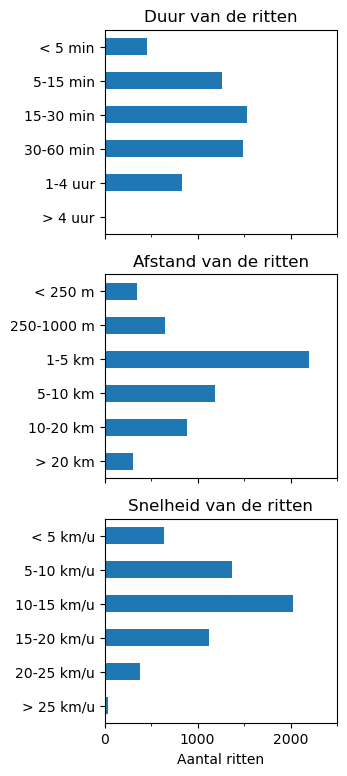

In [30]:
# Plot categorical graphs.

def plot_hbar_cat(ax, df, bins, labels, title='', xslc=[0, 2500, 1000]):
    df[f'{var}_cat'] = pd.cut(df[var], bins=bins, labels=labels)
    ax = df[['entity_id', f'{var}_cat']].groupby(f'{var}_cat', observed=False).count().plot.barh(stacked=True, legend=False, ax=ax)
    ax.invert_yaxis()
    ax.axes.get_yaxis().get_label().set_visible(False)
    # ax.axes.get_xaxis().set_label_text("Aantal ritten")
    ax.set_xlim(xslc[0], xslc[1])
    ax.set_xticks(range(xslc[0], xslc[1], xslc[2]))
    ax.set_title(title)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(3, 9), sharex=True)

var = 'duur_h'
bins = [0.00, 0.0833, 0.25, 0.50, 1.00, 4.00, np.inf]
labels = ['< 5 min', '5-15 min', '15-30 min', '30-60 min', '1-4 uur', '> 4 uur']
plot_hbar_cat(axs[0], df_ritten, bins, labels, title='Duur van de ritten')

var = 'afstand_km'
bins = [0.00, 0.25, 1.00, 5.00, 10.00, 20.00, np.inf]
labels = ['< 250 m', '250-1000 m', '1-5 km', '5-10 km', '10-20 km', '> 20 km']
plot_hbar_cat(axs[1], df_ritten, bins, labels, title='Afstand van de ritten')

var = 'snelheid_mean_kph'
bins = [0.00, 5.00, 10.00, 15.00, 20.00, 25.00, np.inf]
labels = ['< 5 km/u', '5-10 km/u', '10-15 km/u', '15-20 km/u', '20-25 km/u', '> 25 km/u']
plot_hbar_cat(axs[2], df_ritten, bins, labels, title='Snelheid van de ritten')

axs[2].axes.get_xaxis().set_label_text("Aantal ritten")


In [31]:
# Remove datapoints outside of the map area 
#   because it would take a very long time to process large areas.
#   TODO: doe dit op ritniveau (verwijderen ritten deels of geheel buiten de target area)
latlon = {
    'latitude': {'center': mapbox_center['lat'], 'extent': mapbox_extent},
    'longitude': {'center': mapbox_center['lon'], 'extent': mapbox_extent},
}
df = opschonen.filter_lat_lon(df, latlon)


In [32]:
# Identify a nice colormap.
import plotly.express as px
fig = px.colors.sequential.swatches_continuous()
fig.show()

# => Simple jet may be best


In [33]:
# Count measurement, rides and users in a hexbin.

import plotly.figure_factory as ff


# agg function to count unique rides and users in the honeycomb.
def n_unique(x):
    return(len(np.unique(x)))

# shared arguments
hexbin_args = {
    'data_frame': df,
    'lat': 'latitude',
    'lon': 'longitude',
    'color_continuous_scale': 'jet',  # bluered
    'min_count': 1,
    'animation_frame': None,
    'width': 1920,
    'height': 1080,
    'opacity': 0.3,
    'zoom': 10,
    'center': mapbox_center,
    'show_original_data': False,
    'labels': {'color': 'N'}, 
    }
layout_args = {
    'mapbox_style': 'open-street-map',
    'coloraxis_showscale': True,
    'mapbox_layers': mapbox_layers,
    'margin': dict(b=0, t=0, l=0, r=0),
    }

# specific arguments
pars = {
    'counts': {
        'color': None,
        'agg_func': None,
        'labels': {'color': 'N'},
        'range_color': [0, 2000],
        },
    'rides': {
        'color': 'rit_id',
        'agg_func': n_unique,
        'labels': {'color': 'ritten'},
        'range_color': [0, 150],
        },
    'users': {
        'color': 'entity_id',
        'agg_func': n_unique,
        'labels': None,
        'range_color': [0, 10],
        },
}

for k, par in pars.items():

    # Replace keys.
    hexbin_args = {**hexbin_args, **par}

    # Plot the data for each month.
    hexbin_args['title'] = yq
    hexbin_args['nx_hexagon'] = np.ceil(
        (df['longitude'].max() - df['longitude'].min()) / hexagon_size,
        ).astype('int')
    fig = ff.create_hexbin_mapbox(**hexbin_args)
    fig.update_layout(**layout_args)
    fig.update_coloraxes(colorbar_tickfont_size=35)

    # Save image
    filestem = f'{yq}_hexbin_{k}'
    output_stem = Path(output_directory, filestem)
    fig.write_html(f"{output_stem}.html")
    fig.write_image(f"{output_stem}.png")
    fig.write_image(f"{output_stem}.pdf")
